In [1]:
import pandas as pd;
import matplotlib.pyplot as plt;

# function to read census data and metadata from files into dataframes
def parse_census_data(data_file, metadata_file):
    
    # create a pandas dataframe for data attribute description
    metadata = pd.read_csv(metadata_file)
    # create a pandas dataframe for the census data
    # the second row in the datafile has to be skipped as it is 
    # the clone of metadata
    data = pd.read_csv(data_file, skiprows=[1])
    # remove the first two columns from the data as these are 
    # just location ID and name of California
    data = data.drop(columns=["GEO_ID", "NAME"])
    # remove all mergin of error data as we will use the percentage
    # margin of errors only during our future calculation
    sm = metadata[metadata['id'].str.contains('^Margin of Error') == False]
    # also get rid of all percent columns as they are redundent; we
    # will use the counts directy
    sm = sm[sm['id'].str.contains('^Percent!!') == False]
    # collect the percent margin of errors for social data in some 
    # other dataframe, these will come handy later
    # pmsm here stands for percent margin of error in social metadata
    pmem = sm[sm['id'].str.contains('^Percent') == True]
    sm = sm[sm['id'].str.contains('^Percent') == False]
    # filter the estimate data and percent margin of errors in those 
    # data in different data frames
    estimate_col_list = sm['GEO_ID'].values.tolist()
    final_data = data.loc[:, data.columns.isin(estimate_col_list)]
    err_col_list = pmem['GEO_ID'].values.tolist()
    final_err = data.loc[:, data.columns.isin(err_col_list)]
    # create a  dictonary object
    dictionary = {'estimates': final_data, 
                  'percent_errors': final_err, 
                  'metadata': metadata}
    return dictionary

# function to construct a hierarchical multi-indexing for census data
def categorize_data(data, metadata):
    # filter the metadata rows that are related with data estimates -- not error percentage
    estimate_meta = metadata[metadata['GEO_ID'].isin(data.iloc[0].index)]
    # metadata of sub population categories have a hierarchical naming structure; so we split
    # the descriptive name of the population statistics
    divided_meta = estimate_meta['id'].str.split('!!', expand=True)
    # the first column just says 'Estimate'; it is not meaningful.
    divided_meta.drop(columns=[0])
    # we update the index of the meta so that we can merge metadata and data together
    divided_meta['id'] = metadata['GEO_ID']
    divided_meta.set_index('id', inplace=True)
    # data need to be transposed for merging.
    dataTs = data.transpose()
    dataTs.rename(columns={0: 'value'}, inplace=True)
    data_meta = pd.merge(divided_meta, dataTs, left_index=True, right_index=True)
    data_meta.drop(columns=[0], inplace=True)
    data_meta.reset_index()
    # now we give the merged data frame's columns some more meaningful title
    data_meta.rename(columns={1:'topic', 2:'category', 3: 'sub-category'}, inplace=True)
    # do a group by to have a hierarchical categorization of the data
    grouped = data_meta.groupby(['topic', 'category', 'sub-category', 'id'], 
                                dropna=False).agg({'value': 'first'})
    # get the categories for grouping date
    index = grouped.index.get_level_values(0)
    category = set(index.values)
    # create a  dictonary object
    dictionary = {'data_group': grouped, 'category': category}
    return dictionary


In [2]:
demographic = parse_census_data('demographic/data.csv', 'demographic/metadata.csv')
economic = parse_census_data('economic/data.csv', 'economic/metadata.csv')
social = parse_census_data('social/data.csv', 'social/metadata.csv')
housing = parse_census_data('housing/data.csv', 'housing/metadata.csv')
economic_grouped = categorize_data(economic['estimates'], economic['metadata'])
econmic_data_groups = economic_grouped['data_group']
economic_categories = economic_grouped['category']

In [3]:
economic_categories

{'CLASS OF WORKER',
 'COMMUTING TO WORK',
 'EMPLOYMENT STATUS',
 'HEALTH INSURANCE COVERAGE',
 'INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)',
 'INDUSTRY',
 'OCCUPATION',
 'PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL'}

In [4]:
commute_status = econmic_data_groups.loc[['INDUSTRY']]
commute_status

value
topic    category                                       sub-category                                       id                  
INDUSTRY Civilian employed population 16 years and over Agriculture, forestry, fishing and hunting, and... DP03_0033E    415545
                                                        Arts, entertainment, and recreation, and accomm... DP03_0043E   1936179
                                                        Construction                                       DP03_0034E   1175234
                                                        Educational services, and health care and socia... DP03_0042E   3904118
                                                        Finance and insurance, and real estate and rent... DP03_0040E   1116974
                                                        Information                                        DP03_0039E    539809
                                                        Manufacturing                                      DP03_0035E   1692820
                                                        Other services, except public administration       DP03_0044E    969511
                                                        Professional, scientific, and management, and a... DP03_0041E   2546055
                                                        Public administration                              DP03_0045E    824869
                                                        Retail trade                                       DP03_0037E   1950499
                                                        Transportation and warehousing, and utilities      DP03_0038E    993917
                                                        Wholesale trade                                    DP03_0036E    525711
                                                        NaN                                                DP03_0032E  18591241

<AxesSubplot:xlabel='topic,category,sub-category'>

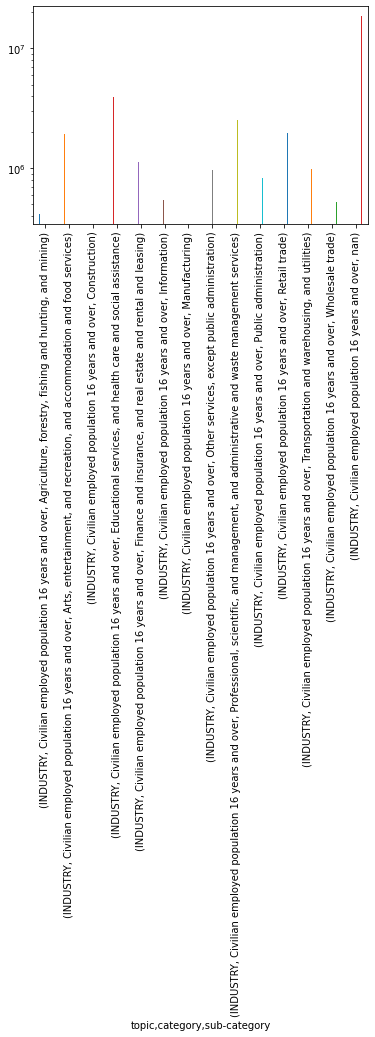

In [5]:
commute_status.unstack(level='id').plot(kind='bar', logy=True, legend=False)

In [6]:
demographic_grouped = categorize_data(demographic['estimates'], demographic['metadata'])
demographic_data_groups = demographic_grouped['data_group']
demographic_categories = demographic_grouped['category']
demographic_categories

{'CITIZEN, VOTING AGE POPULATION',
 'HISPANIC OR LATINO AND RACE',
 'RACE',
 'Race alone or in combination with one or more other races',
 'SEX AND AGE',
 'Total housing units'}

In [7]:
sex_and_age = demographic_data_groups.loc[['SEX AND AGE']]
sex_and_age

value
topic       category         sub-category                      id                    
SEX AND AGE Total population 10 to 14 years                    DP05_0007E   2575463.0
                             15 to 19 years                    DP05_0008E   2565170.0
                             16 years and over                 DP05_0020E  31284669.0
                             18 years and over                 DP05_0021E  30261351.0
                                                               DP05_0025E  30261351.0
                                                               DP05_0026E  14915402.0
                                                               DP05_0027E  15345949.0
                                                               DP05_0028E        97.2
                             20 to 24 years                    DP05_0009E   2751567.0
                             21 years and over                 DP05_0022E  28663349.0
                             25 to 34 years                    DP05_0010E   5967864.0
                             35 to 44 years                    DP05_0011E   5205887.0
                             45 to 54 years                    DP05_0012E   5101422.0
                             5 to 9 years                      DP05_0006E   2468226.0
                             55 to 59 years                    DP05_0013E   2473228.0
                             60 to 64 years                    DP05_0014E   2237101.0
                             62 years and over                 DP05_0023E   6769198.0
                             65 to 74 years                    DP05_0015E   3172271.0
                             65 years and over                 DP05_0024E   5486041.0
                                                               DP05_0029E   5486041.0
                                                               DP05_0030E   2437872.0
                                                               DP05_0031E   3048169.0
                                                               DP05_0032E        80.0
                             75 to 84 years                    DP05_0016E   1600241.0
                             85 years and over                 DP05_0017E    713529.0
                             Female                            DP05_0003E  19757199.0
                             Male                              DP05_0002E  19526298.0
                             Median age (years)                DP05_0018E        36.5
                             Sex ratio (males per 100 females) DP05_0004E        98.8
                             Under 18 years                    DP05_0019E   9022146.0
                             Under 5 years                     DP05_0005E   2451528.0
                             NaN                               DP05_0001E  39283497.0

In [8]:
race = demographic_data_groups.loc[['Race alone or in combination with one or more other races']]
race

value
topic                                              category         sub-category                               id                    
Race alone or in combination with one or more o... Total population American Indian and Alaska Native          DP05_0066E    762733.0
                                                                    Asian                                      DP05_0067E   6551732.0
                                                                    Black or African American                  DP05_0065E   2766478.0
                                                                    Native Hawaiian and Other Pacific Islander DP05_0068E    323042.0
                                                                    Some other race                            DP05_0069E   5944874.0
                                                                    White                                      DP05_0064E  25048942.0
                                                                    NaN                                        DP05_0063E  39283497.0

In [9]:
housing_grouped = categorize_data(housing['estimates'], housing['metadata'])
housing_data_groups = housing_grouped['data_group']
housing_categories = housing_grouped['category']

In [10]:
housing_categories

{'BEDROOMS',
 'GROSS RENT',
 'GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI)',
 'HOUSE HEATING FUEL',
 'HOUSING OCCUPANCY',
 'HOUSING TENURE',
 'MORTGAGE STATUS',
 'OCCUPANTS PER ROOM',
 'ROOMS',
 'SELECTED CHARACTERISTICS',
 'SELECTED MONTHLY OWNER COSTS (SMOC)',
 'SELECTED MONTHLY OWNER COSTS AS A PERCENTAGE OF HOUSEHOLD INCOME (SMOCAPI)',
 'UNITS IN STRUCTURE',
 'VALUE',
 'VEHICLES AVAILABLE',
 'YEAR HOUSEHOLDER MOVED INTO UNIT',
 'YEAR STRUCTURE BUILT'}

In [18]:
housing_data_groups.loc[['UNITS IN STRUCTURE']]

value
topic      category                   sub-category     id                   
GROSS RENT Occupied units paying rent $1,000 to $1,499 DP04_0129E  1629755.0
                                      $1,500 to $1,999 DP04_0130E  1323648.0
                                      $2,000 to $2,499 DP04_0131E   762419.0
                                      $2,500 to $2,999 DP04_0132E   391290.0
                                      $3,000 or more   DP04_0133E   383503.0
                                      $500 to $999     DP04_0128E   939983.0
                                      Less than $500   DP04_0127E   277350.0
                                      Median (dollars) DP04_0134E     1503.0
                                      No rent paid     DP04_0135E   181738.0
                                      NaN              DP04_0126E  5707948.0